- 2020.07.31 kouui

- 2020.08.07 kouui Grotrian-plot, data-format

- 2020.08.18 equations, SE(point), net rate, detail balance

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

---

In [2]:
import numpy as np

%matplotlib inline
#%matplotlib tk
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls
from src.Atomic import Collision, SEsolver

from src.Util import Class

from src.Visual import Grotrian

import src.Constants as Cst
from src.Atomic import LTELib

from src.Function.StatisticalEquilibrium import LibClass as SELib

---

In [4]:
atom, paths = AtomCls.InitAtom("../../data/conf/Ca_II.conf")

In [7]:
Class.help(atom)

Attributes
----------------------------------------------------------------------
name                         type               value/len/shape
----------------------------------------------------------------------

isPrint                      bool               v: False
filepath_dict                dict               l: 6
Title                        str                v: Ca II H/K ...
Z                            int                v: 20
Element                      str                v: Ca
nLevel                       int                v: 6
Mass                         float              v: 40.08
Abun                         float              v: 2.5118864315095823e-06
Level                        recarray           ---
  |-> erg                    float64 array      s: (6,)
  |-> g                      uint8 array        s: (6,)
  |-> stage                  uint8 array        s: (6,)
  |-> gamma                  float64 array      s: (6,)
  |-> isGround               bool array

In [8]:
paths

{'folder': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II',
 'conf': '/Users/liu/kouui/workspace/spectra/data/conf/Ca_II.conf',
 'Level': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Ca_II.Level',
 'Aji': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Einstein_A/Nist.Aji',
 'CEe': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Collisional_Excitation/RH.Electron',
 'CIe': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Collisional_Ionization/RH.Electron',
 'PI': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Photoionization/RH.Alpha',
 'RadiativeLine': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Ca_II.RadiativeLine',
 'Grotrian': '/Users/liu/kouui/workspace/spectra/data/atom/Ca_II/Ca_II.Grotrian'}

# SE (point)

**radiative ionization/recombination**

- photoionization

    $$
    R_{ik} = 4\pi \int_{0}^{\lambda_0} \alpha_{ik}(\lambda) (hc/\lambda)^{-1} J(\lambda) d\lambda
    $$
    
- stimulated radiative recombination

    $$
    R_{ki}^{stim} = \frac{n_i^{LTE}}{n_k^{LTE}} 4\pi \int_{0}^{\lambda_{0}} \alpha_{ik}(\lambda) (hc/\lambda)^{-1} J(\lambda) e^{-hc/\lambda kT} d\lambda
    $$
    
- spontaneous radiative recombination

    $$
    R_{ki}^{spon} = \frac{n_i^{LTE}}{n_k^{LTE}} 4\pi \int_{0}^{\lambda} \alpha_{ik}(\lambda) (hc/\lambda)^{-1} (2hc^{2}/{\lambda}^5) e^{-hc/\lambda kT} d\lambda
    $$
    
where we have
    $$J(\lambda) = B_{\lambda}(T_{r}) \quad (Planck \; Function)$$

**radiative excitation/de-excitation**

- photo excitation/de-excitation :

    compute Einstein $B_{ij}$ and $B_{ji}$ base on Einstein's relation
    
    $$
    B_{ji} = A_{ji} / (2 h c^{2} \lambda^{5} )
    $$
    
    $$
    B_{ij} = B_{ji} \frac{g_{j}}{g_{i}}
    $$
    
    then compute the rate $[s^{-1}]$ of

    $$
    B_{ij} \bar{J_{\lambda_{0}}^{\varphi}} = B_{ij} \int_{0}^{\infty} J_{\lambda} \varphi(\lambda-\lambda_{0}) d\lambda
    $$
    
    where $\varphi(\lambda-\lambda_{0})$ is the absorption profile (Voigt profile) with
    
    $$
    \int_{0}^{\infty} \varphi(\lambda-\lambda_{0}) d\lambda \equiv 1
    $$

    - stimulated de-excitation

    $$
    B_{ji} \bar{J_{\lambda_{0}}^{\chi}} = B_{ji} \int_{0}^{\infty} J_{\lambda} \chi(\lambda-\lambda_{0}) d\lambda
    $$
    
    where $\chi(\lambda-\lambda_{0})$ is the emission profile, and with the situation of **complete redistribution** we have
    
    $$
    \chi(\lambda-\lambda_{0}) = \varphi(\lambda-\lambda_{0})
    $$
    
    therefore, by assuming 
    
    $$
    J(\lambda) = B_{\lambda_{0}}(T_{r}) \quad (Planck \; Function)
    $$
    
    we have
    
    $$
    B_{ij} \bar{J_{\lambda_{0}}^{\varphi}} = B_{ij} B_{\lambda_{0}}(T_{r})
    $$
    
    $$
    B_{ji} \bar{J_{\lambda_{0}}^{\chi}} = B_{ji} B_{\lambda_{0}}(T_{r})
    $$

**collisional excitation/de-excitation**

$$
C_{ij} = \frac{8.63e-6 \times (\Omega_{ij}) }{g_{i} T_{e}^{1/2}}  \exp{\frac{-E_{ji}}{kT_{e}} } \quad [s^{-1}cm^{3}]
$$

$$
C_{ji} = \frac{n_i^{LTE}}{n_j^{LTE}} C_{ij}
$$
    
**collisional ionization/recombination**

$$
C_{ik} = (\Omega_{ik}) * \exp{\frac{-E_{ki}}{kT_{e}}} * \sqrt{T_{e}}, \quad [s^{-1}cm^{3}]
$$

$$
C_{ki} = \frac{n_i^{LTE}}{n_k^{LTE}} C_{ik}
$$

**statistical equilibrium equations**
    
given the collisional transition matrix $n_{e}{CM}_{ij}$ and the radiative transition matrix ${RM}_{ij}$,

  - matrix ${CM}_{ij}$ is constructed from array $C_{ij}$, $C_{ji}$, $C_{ik}$, $C_{ki}$
  
  - matrix ${RM}_{ij}$ is constructed from array $A_{ji}$, $B_{ij}\bar{J_{\lambda_{0}}^{\varphi}}$, $B_{ji} \bar{J_{\lambda_{0}}^{\chi}}$, $R_{ik}$, $R_{ki}^{stim}$, $R_{ki}^{spon}$


solve the statistical equilibrium equations

$$
\sum_{j \neq i} n_j ({RM}_{ji}+n_{e}{CM}_{ji}) - n_i \sum_{j \neq i}({RM}_{ij}+n_{e}{CM}_{ij}) = 0
$$
    
with 

$$
\sum_{i}n_{i} = 1
$$

In [24]:
Te = 1E4
Ne = 1E11
Tr = 6E3

# n_LTE : LTE population (summed up to 1)
# nj_by_ni_Line : nj/ni for line transitions
# nj_by_ni_Cont : nj/ni for Continuum transitions
n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne)

Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)

##  ij : ij + ik
Cij = SELib.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

n_SE = SELib.solve_SE(atom, 
                     Ne, Cji, Cij, 
                     Bji_Jbar, Bij_Jbar, 
                     Rki_spon, Rki_stim, Rik)

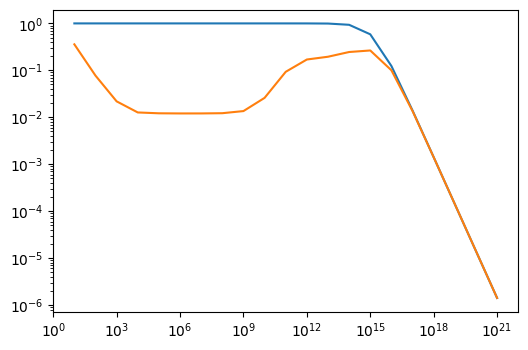

In [17]:
N = 21
Ne_arr = np.logspace(1,21,N)
n_LTE_arr = np.zeros((N,6))
n_SE_arr = np.zeros((N,6))

Tr = 0.3E4
Te = 1E4

for i in range(N):
    Ne = Ne_arr[i]
    n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne)

    Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
    Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)

    ##  ij : ij + ik
    Cij = SELib.get_Cij(atom, Te)
    Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

    n_SE = SELib.solve_SE(atom, 
                         Ne, Cji, Cij, 
                         Bji_Jbar, Bij_Jbar, 
                         Rki_spon, Rki_stim, Rik)
    
    n_LTE_arr[i,:] = n_LTE[:]
    n_SE_arr[i,:] = n_SE[:]


ionization_ratio_LTE = n_LTE_arr[:,-1] / n_LTE_arr[:,:].sum(axis=1)
ionization_ratio_SE = n_SE_arr[:,-1] / n_SE_arr[:,:].sum(axis=1)
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100)
ax.plot(Ne_arr, ionization_ratio_LTE)
ax.plot(Ne_arr, ionization_ratio_SE)

ax.set_xscale("log")
ax.set_yscale("log")
plt.show()


In [23]:
print(f"Electron temperature  = {Te:.1E}")
print(f"Electron density      = {Ne:.1E}")
print(f"Radiation temperature = {Tr:.1E}")
print("SE  :")
for v in n_SE:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in n_LTE:
    print(f"{v:.4E}",end="  ")

Electron temperature  = 1.0E+04
Electron density      = 1.0E+11
Radiation temperature = 6.0E+03
SE  :
3.6527E-01  2.7457E-02  4.0766E-02  8.7318E-04  1.6506E-03  5.6398E-01  
LTE :
3.9829E-05  1.1176E-05  1.6618E-05  1.0619E-06  2.0568E-06  9.9993E-01  

In [25]:
print(f"Electron temperature  = {Te:.1E}")
print(f"Electron density      = {Ne:.1E}")
print(f"Radiation temperature = {Tr:.1E}")
print("SE  :")
for v in n_SE:
    print(f"{v:.4E}",end="  ")
print(f"\nLTE :")
for v in n_LTE:
    print(f"{v:.4E}",end="  ")

Electron temperature  = 1.0E+04
Electron density      = 1.0E+11
Radiation temperature = 6.0E+03
SE  :
3.4882E-01  2.6225E-02  3.8937E-02  8.3385E-04  1.5762E-03  5.8361E-01  
LTE :
3.9829E-05  1.1176E-05  1.6618E-05  1.0619E-06  2.0568E-06  9.9993E-01  

# Detail Balance of radiative transitions

under LTE, assuming

$$
T_{electron}=T_{radiation}
$$

then calculate the net rate in each line/continuum radiative transition

In [5]:
Te = 1E4
Ne = 1E12
Tr = Te
#--------------

#n_LTE0, ni_LTE0, nj_LTE0 = SELib.ni_nj_LTE_v0(atom,_Te,_Ne)
#_nj_by_ni_Line = nj_LTE0[:atom.nLine] / ni_LTE0[:atom.nLine]
#_nj_by_ni_Cont = nj_LTE0[atom.nLine:] / ni_LTE0[atom.nLine:]

#--------------
n_LTE , nj_by_ni_Line, nj_by_ni_Cont = SELib.ni_nj_LTE(atom, Te, Ne)

Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont, _Tr=Tr)
Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)
Cij = SELib.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, np.append(nj_by_ni_Line,nj_by_ni_Cont) )

n_SE = SELib.solve_SE(atom, 
                     Ne, Cji, Cij, 
                     Bji_Jbar, Bij_Jbar, 
                     Rki_spon, Rki_stim, Rik)
#--------------

#ni = n_SE[ np.append(atom.Line.idxI,atom.Cont.idxI) ]
#nj = n_SE[ np.append(atom.Line.idxJ,atom.Cont.idxJ) ]
#--------------

print("Line Transitions", end="\n")
for _lineIdx in range(atom.nLine):
    _nj_by_ni = nj_by_ni_Line[_lineIdx]
    print(f"wavelength : {atom.Line.w0_AA[_lineIdx]:.5E}[A]", end="    ")
    print("net rate = ", end="")
    netrate = (atom.Line.AJI[_lineIdx] + Bji_Jbar[_lineIdx]) * _nj_by_ni \
               - Bij_Jbar[_lineIdx]
    print(f"{netrate:+.4E}")

print()
print("Continuum Transitions", end="\n")
for _contIdx in range(atom.nCont):
    _nj_by_ni = nj_by_ni_Cont[_contIdx]
    print(f"wavelength : {atom.Cont.w0_AA[_contIdx]:.5E}[A]", end="    ")
    print("net rate = ", end="")
    netrate = (Rki_spon[_contIdx]+Rki_stim[_contIdx]) * _nj_by_ni - \
               Rik[_contIdx] 
    print(f"{netrate:+.4E}")


Line Transitions
wavelength : 7.32590E+03[A]    net rate = +2.2204E-16
wavelength : 7.29348E+03[A]    net rate = +3.3307E-16
wavelength : 3.96959E+03[A]    net rate = -1.3970E-09
wavelength : 3.93478E+03[A]    net rate = +0.0000E+00
wavelength : 1.64785E+06[A]    net rate = +0.0000E+00
wavelength : 8.66452E+03[A]    net rate = +2.3283E-10
wavelength : 8.50036E+03[A]    net rate = -5.8208E-11
wavelength : 8.71032E+03[A]    net rate = +0.0000E+00
wavelength : 8.54443E+03[A]    net rate = +0.0000E+00
wavelength : 4.48649E+05[A]    net rate = +0.0000E+00

Continuum Transitions
wavelength : 1.04437E+03[A]    net rate = +3.5527E-15
wavelength : 1.21800E+03[A]    net rate = +3.4106E-13
wavelength : 1.21890E+03[A]    net rate = +2.2737E-13
wavelength : 1.41723E+03[A]    net rate = +5.6843E-14
wavelength : 1.42172E+03[A]    net rate = +1.7053E-13


## Plots

### Transition rate plot in Grotrian diagram

#### show Grotrian

`Grotrian.Grotrian` to initialize a Grotrian object

`.make_fig` to setup a Grotrian level plot

`.show_fig` to show figure. 

every time once the figure has been showed, you need to `.make_fig` again to setup the plot

In [7]:
gro = Grotrian.Grotrian(_atom=atom)

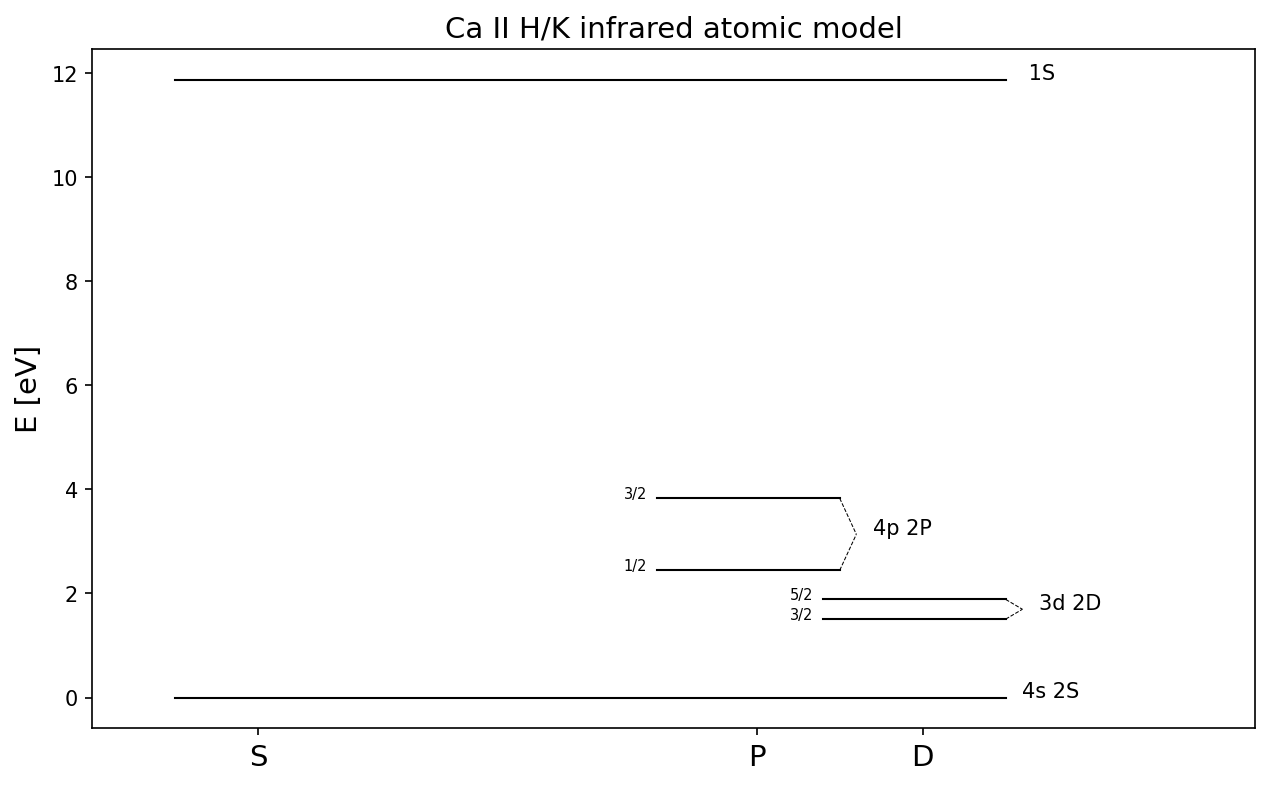

In [8]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)
gro.show_fig()

`plot_transitions` to connect transitions between levels

`_text_selection` keyword could be 

  - "all" : to plot all transitions in the configuration file

  -  "wavelength" : transitions in the configuration file with wavelength text (default)
  
  - list/tuple of wavelength text : to select the specific transitions

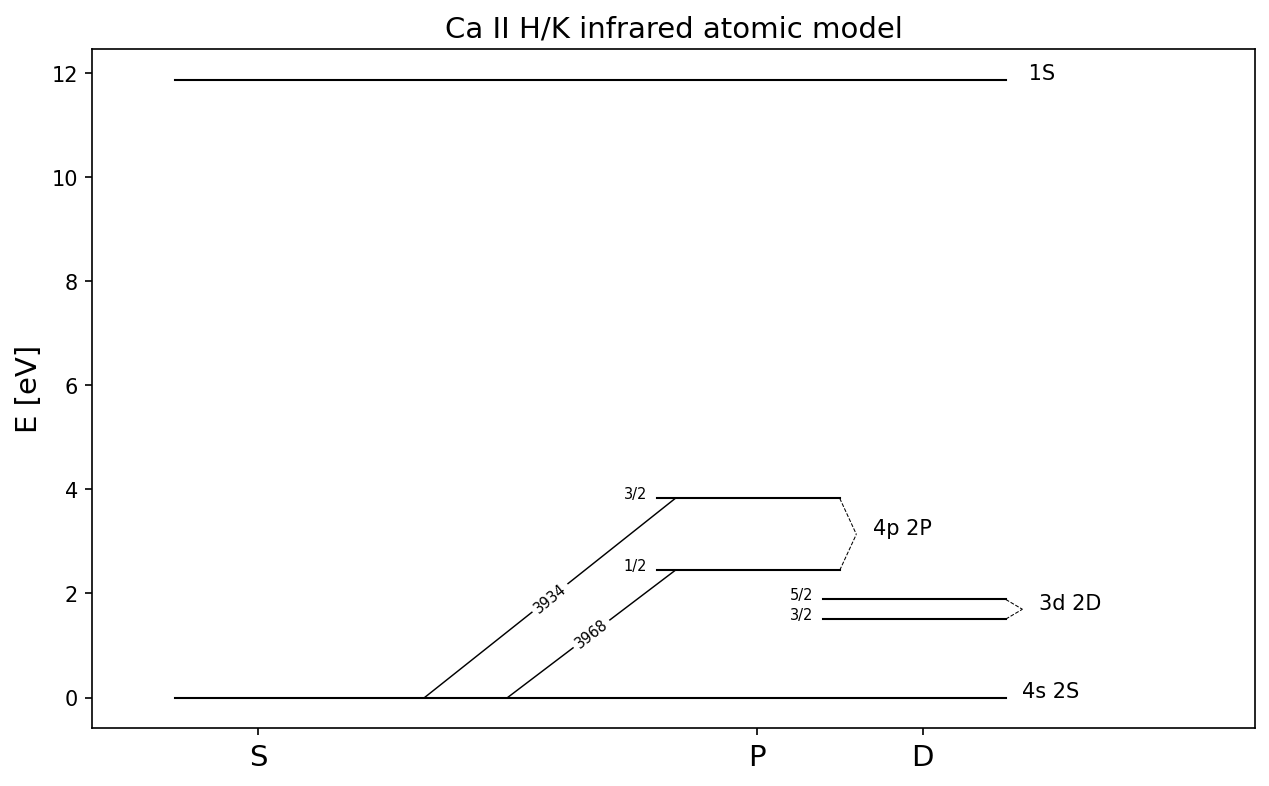

In [9]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

text_selection = ("3968", "3934") # "wavelength", "all"
gro.plot_transitions(_text_selection=text_selection)
gro.show_fig()

#### radiative transition rate

in NLTE, now we set

$$
T_{electron} \neq T_{radiation}
$$

to have net radiative transition rates

in `.plot_transition_rate` method,

  - `_abserr` defines an lower boundary that if 
  
      $$0 \le |rate| < abserror$$
      
    then the transition rate arrow will not be plotted. (default : 1E-5)

compute transition rates and solve statistical equilibrium equations for level population

In [10]:
Te = 8E3
Ne = 1E12
Tr = 6E3

#--------------
n_LTE , nj_by_ni_Line_LTE, nj_by_ni_Cont_LTE = SELib.ni_nj_LTE(atom, Te, Ne)
nj_by_ni_LTE = np.append(nj_by_ni_Line_LTE,nj_by_ni_Cont_LTE)

Rik, Rki_stim, Rki_spon = SELib.bf_R_rate(atom, Te, nj_by_ni_Cont_LTE, _Tr=Tr)
Bij_Jbar, Bji_Jbar = SELib.B_Jbar(atom, _Tr=Tr)
Cij = SELib.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji( Cij, nj_by_ni_LTE )

n_SE = SELib.solve_SE(atom, 
                     Ne, Cji, Cij, 
                     Bji_Jbar, Bij_Jbar, 
                     Rki_spon, Rki_stim, Rik)
#--------------

ni_Line = n_SE[ atom.Line.idxI ]
nj_Line = n_SE[ atom.Line.idxJ ]
ni_Cont = n_SE[ atom.Cont.idxI ]
nj_Cont = n_SE[ atom.Cont.idxJ ]
ni = np.append( ni_Line, ni_Cont )
nj = np.append( nj_Line, nj_Cont )
#--------------
idxI = np.append( atom.Line.idxI, atom.Cont.idxI )
idxJ = np.append( atom.Line.idxJ, atom.Cont.idxJ )

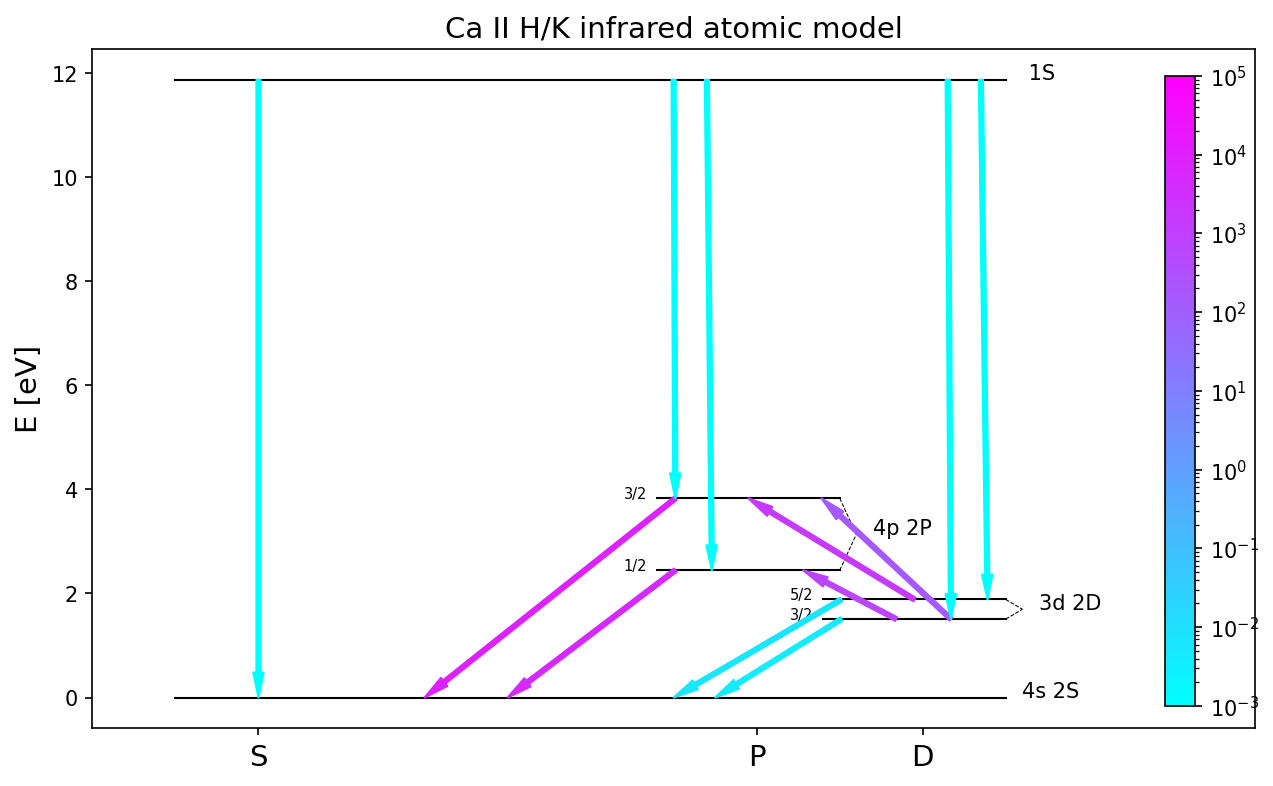

In [11]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)


#--------------
rate_rad = np.append( Bji_Jbar*nj_Line + 
                  atom.Line.AJI*nj_Line - 
                  Bij_Jbar*ni_Line,
                  Rki_stim*nj_Cont +
                  Rki_spon*nj_Cont - 
                  Rik*ni_Cont )
#--------------

gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate_rad, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)

#### collisional transition rate

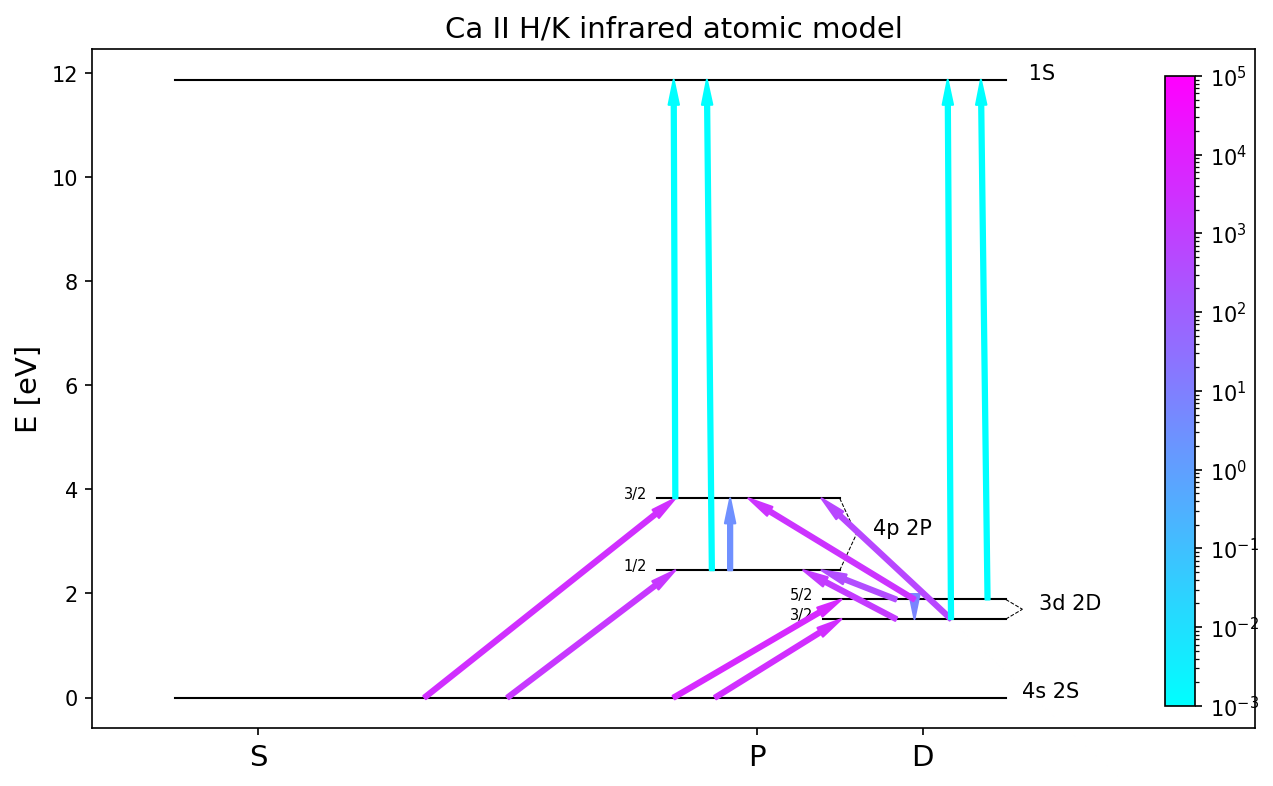

In [12]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)


#--------------
rate_col = (Cji*nj - Cij*ni)*Ne
#--------------


gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate_col, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)

we found that, **collisional transition plays an important role in this atomic system**

#### radiative + collisional

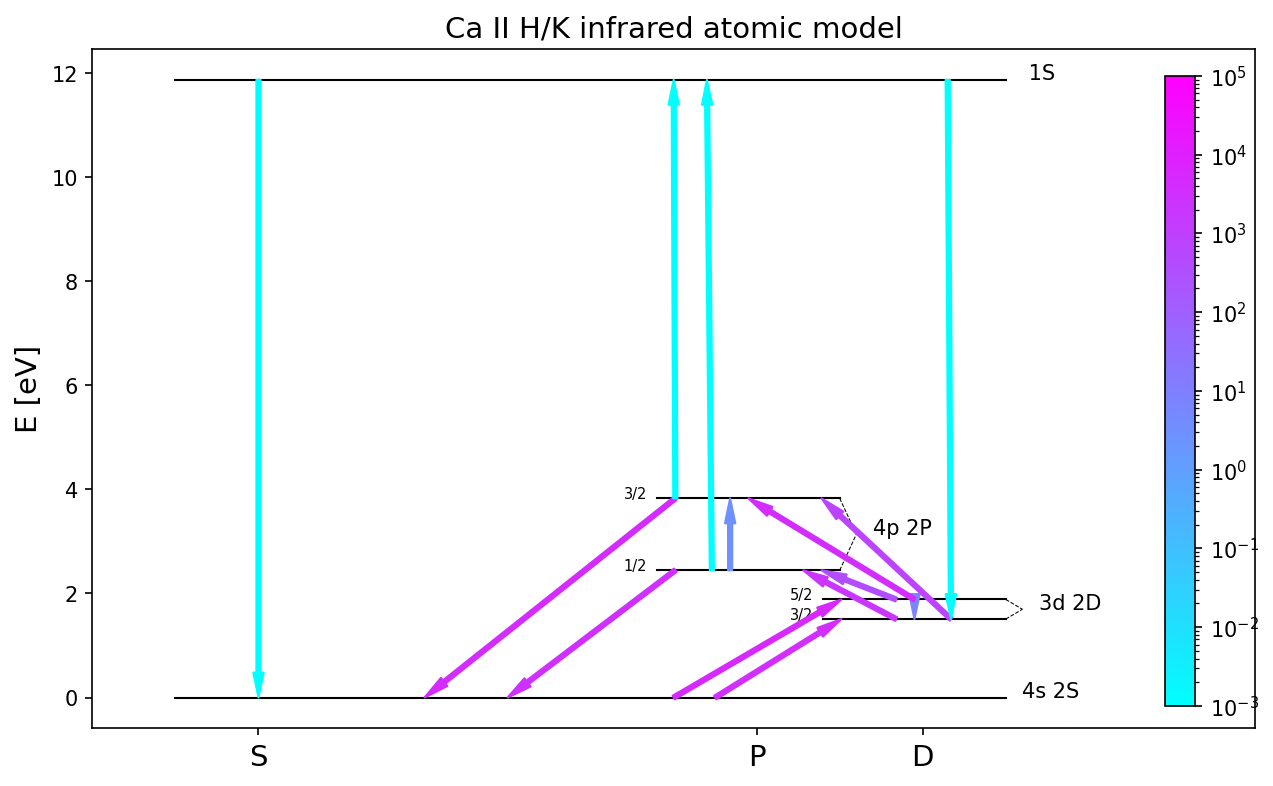

In [13]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)

#--------------
rate = rate_rad + rate_col
#--------------

gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5)

---

##### transition plot respective to a single level

furthermore, by applying the `_level_ctj_without_prefix` keyword a tuple/list of `(configuration with out prefix, term, J)`, we are able to select the  ralated transitions

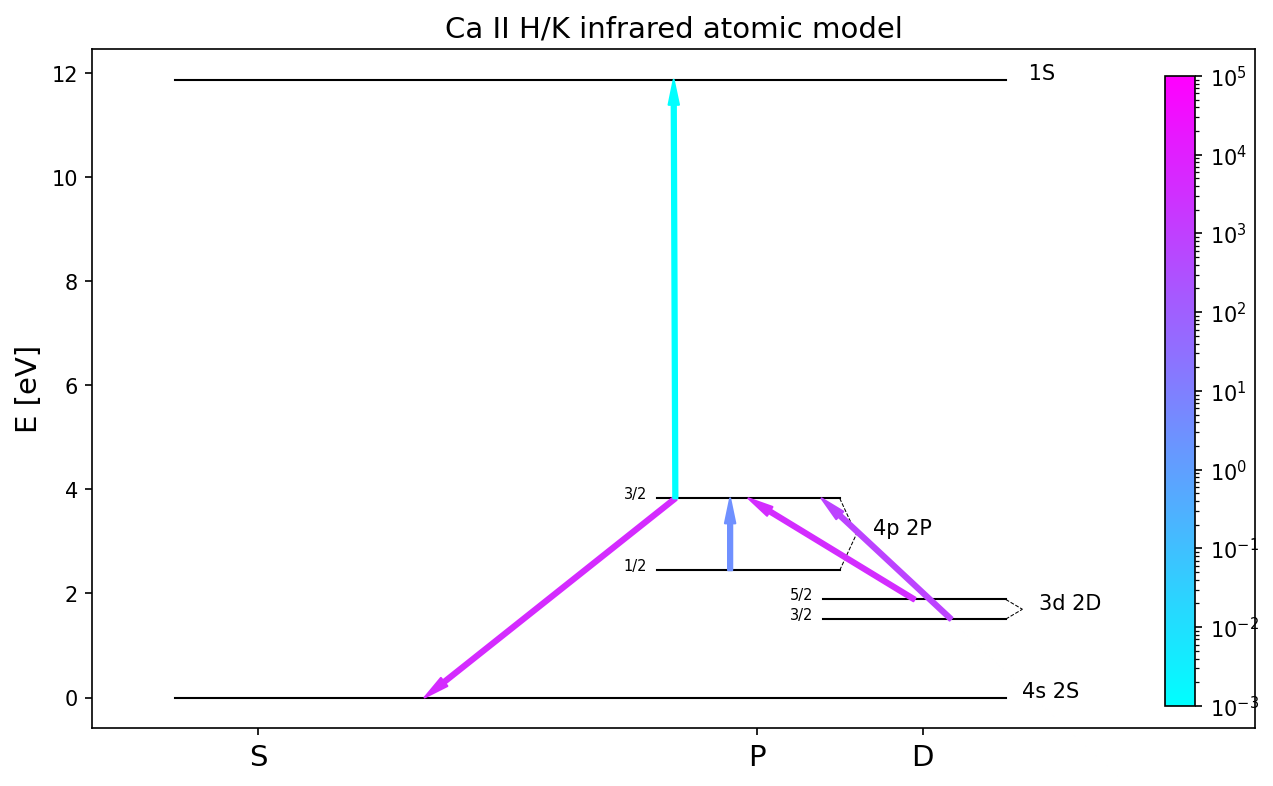

In [14]:
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

cmap = plt.get_cmap('cool')
norm = LogNorm(1E-3, 1E5, clip=True)

gro.plot_transition_rate(_idxI=idxI, 
                         _idxJ=idxJ, 
                         _rate=rate, 
                         _direction="j->i",
                         _cmap=cmap, _norm=norm, _abserr=1E-5,
                         _level_ctj_without_prefix=("4p","2P","3/2"))